*Copyright (c) Microsoft Corporation. All rights reserved.*

*Licensed under the MIT License.*

# Text Classification of SST-2 Sentences using BERT

# Before You Start

> **Tip**: If you want to run through the notebook quickly, you can set the **`QUICK_RUN`** flag in the cell below to **`True`**. This will run the notebook on a small subset of the data and a use a smaller number of epochs. 

If you run into CUDA out-of-memory error or the jupyter kernel dies constantly, try reducing the `BATCH_SIZE` and `MAX_LEN`, but note that model performance will be compromised. 

In [1]:
## Set QUICK_RUN = True to run the notebook on a small subset of data and a smaller number of epochs.
QUICK_RUN = True

In [2]:
import sys
sys.path.append("../../")
import os
import json
import pandas as pd
import numpy as np
import scrapbook as sb
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn

from utils_nlp.dataset.multinli import load_pandas_df 
from utils_nlp.models.bert.sequence_classification import BERTSequenceClassifier
from utils_nlp.models.bert.common import Language, Tokenizer
from utils_nlp.common.timer import Timer

I0109 11:10:53.883785 140364218693440 file_utils.py:37] PyTorch version 1.3.1 available.
/home/maidap/anaconda3/envs/interpret_cpu_extern/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/maidap/anaconda3/envs/interpret_cpu_extern/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/maidap/anaconda3/envs/interpret_cpu_extern/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be underst

In [3]:
from interpret_text.msra.MSRAExplainer import MSRAExplainer

## Introduction
In this notebook, we fine-tune and evaluate a pretrained [BERT](https://arxiv.org/abs/1810.04805) model on a subset of the [SST-2](https://nlp.stanford.edu/sentiment/index.html/) dataset. To run this notebook, we used the SST-2 data files provided [here](https://github.com/AcademiaSinicaNLPLab/sentiment_dataset). You should download files matching data/sst2.binary.* into a folder and point DATA_FOLDER (below) to that folder.

We use a [sequence classifier](https://github.com/microsoft/nlp/blob/master/utils_nlp/models/bert/sequence_classification.py) that wraps [Hugging Face's PyTorch implementation](https://github.com/huggingface/pytorch-pretrained-BERT) of Google's [BERT](https://github.com/google-research/bert).

### Set parameters
Here we set some parameters that we use for our modeling task.

In [4]:
TRAIN_DATA_FRACTION = 1
TEST_DATA_FRACTION = 1
NUM_EPOCHS = 1

if QUICK_RUN:
    TRAIN_DATA_FRACTION = 0.01
    TEST_DATA_FRACTION = 0.01
    NUM_EPOCHS = 1

if torch.cuda.is_available():
    BATCH_SIZE = 32
else:
    BATCH_SIZE = 8

DATA_FOLDER = "../../../data/sst2"
BERT_CACHE_DIR = "./temp/sst2"
LANGUAGE = Language.ENGLISH
TO_LOWER = True
MAX_LEN = 150
BATCH_SIZE_PRED = 512
TRAIN_SIZE = 0.6
LABEL_COL = "labels" 
TEXT_COL = "sentences"

## Read Dataset
We start by loading a subset of the data. The following function also downloads and extracts the files, if they don't exist in the data folder.

The SST-2 dataset is dataset of Rotten Tomatoes movie reviews mainly used for natural language inference (NLI) tasks, where the inputs are sentences and the labels are binary (positive or negative) sentiment indicators. 

We start by loading the data for training and testing:

In [5]:
def load_data(fpath):
    df_dict = {LABEL_COL: [], TEXT_COL: []}
    with open(fpath, 'r') as f:
        label_start = 0
        sentence_start = 2
        for line in f:
            label = int(line[label_start])
            sentence = line[sentence_start:]
            df_dict['labels'].append(label)
            df_dict['sentences'].append(sentence)
    return pd.DataFrame.from_dict(df_dict)

df_train = load_data(os.path.join(DATA_FOLDER, 'stsa.binary.train'))
df_test = load_data(os.path.join(DATA_FOLDER, 'stsa.binary.test'))


if QUICK_RUN:
    df_train = df_train.sample(frac=TRAIN_DATA_FRACTION).reset_index(drop=True)
    df_test = df_test.sample(frac=TEST_DATA_FRACTION).reset_index(drop=True)

These are the two classes in the dataset, where "1" corresponds to a positive review and "0" corresponds to a negative review. We don't need to encode the labels as they are already integers.

In [10]:
# display stats and examples for label types
print(df_train[[LABEL_COL, TEXT_COL]].head())
print(df_train[LABEL_COL].value_counts())

# create training and testing labels
labels_train = df_train[LABEL_COL]
labels_test = df_test[LABEL_COL]

   labels                                          sentences
0       1  strange occurrences build in the mind of the v...
1       1  jones ... makes a great impression as the writ...
2       0  at best , cletis tout might inspire a trip to ...
3       0  with a romantic comedy plotline straight from ...
4       1  enough may pander to our basest desires for pa...
1    35
0    34
Name: labels, dtype: int64


In [11]:
num_labels = len(np.unique(labels_train))
print("Number of unique labels: {}".format(num_labels))
print("Number of training examples: {}".format(df_train.shape[0]))
print("Number of testing examples: {}".format(df_test.shape[0]))

Number of unique labels: 2
Number of training examples: 69
Number of testing examples: 18


## Tokenize and Preprocess

Before we start training, we tokenize the text documents and convert them to lists of tokens. The following steps instantiate a `BERT tokenizer` given the language, and tokenize the text of the training and testing sets.

In [12]:
tokenizer = Tokenizer(LANGUAGE, to_lower=TO_LOWER, cache_dir=BERT_CACHE_DIR)

tokens_train = tokenizer.tokenize(list(df_train[TEXT_COL]))
tokens_test = tokenizer.tokenize(list(df_test[TEXT_COL]))

print(tokens_train)

I0109 11:29:38.392958 140364218693440 file_utils.py:224] https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt not found in cache, downloading to /tmp/tmpyicdmvao
100%|██████████| 231508/231508 [00:00<00:00, 4641185.61B/s]
I0109 11:29:38.580375 140364218693440 file_utils.py:237] copying /tmp/tmpyicdmvao to cache at ./temp/sst2/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
I0109 11:29:38.582956 140364218693440 file_utils.py:241] creating metadata file for ./temp/sst2/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
I0109 11:29:38.587434 140364218693440 file_utils.py:250] removing temp file /tmp/tmpyicdmvao
I0109 11:29:38.589242 140364218693440 tokenization.py:190] loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at ./temp/sst2/26bc1ad

[['strange', 'occurrences', 'build', 'in', 'the', 'mind', 'of', 'the', 'viewer', 'and', 'take', 'on', 'extreme', 'urgency', '.'], ['jones', '.', '.', '.', 'makes', 'a', 'great', 'impression', 'as', 'the', 'writer', '-', 'director', 'of', 'this', 'little', '$', '1', '.', '8', 'million', 'charm', '##er', ',', 'which', 'may', 'not', 'be', 'cutting', '-', 'edge', 'indie', 'filmmaking', 'but', 'has', 'a', 'huge', 'heart', '.'], ['at', 'best', ',', 'cl', '##eti', '##s', 'to', '##ut', 'might', 'inspire', 'a', 'trip', 'to', 'the', 'video', 'store', '-', '-', 'in', 'search', 'of', 'a', 'better', 'movie', 'experience', '.'], ['with', 'a', 'romantic', 'comedy', 'plot', '##line', 'straight', 'from', 'the', 'ages', ',', 'this', 'cinderella', 'story', 'does', 'n', "'", 't', 'have', 'a', 'single', 'surprise', 'up', 'its', 'sleeve', '.'], ['enough', 'may', 'pan', '##der', 'to', 'our', 'bases', '##t', 'desires', 'for', 'pay', '##back', ',', 'but', 'unlike', 'many', 'revenge', 'fantasies', ',', 'it', 'u

In addition, we perform the following preprocessing steps in the cell below:
- Convert the tokens into token indices corresponding to the BERT tokenizer's vocabulary
- Add the special tokens [CLS] and [SEP] to mark the beginning and end of a sentence, respectively
- Pad or truncate the token lists to the specified max length. In this case, `MAX_LEN = 150`
- Return mask lists that indicate the paddings' positions
- Return token type id lists that indicate which sentence the tokens belong to (not needed for one-sequence classification)

*See the original [implementation](https://github.com/google-research/bert/blob/master/run_classifier.py) for more information on BERT's input format.*

In [13]:
tokens_train, mask_train, _ = tokenizer.preprocess_classification_tokens(tokens_train, MAX_LEN)
tokens_test, mask_test, _ = tokenizer.preprocess_classification_tokens(tokens_test, MAX_LEN)

## Sequence Classifier Model
Next, we use a sequence classifier that loads a pre-trained BERT model, given the language and number of labels.

In [14]:
classifier = BERTSequenceClassifier(language=LANGUAGE, num_labels=num_labels, cache_dir=BERT_CACHE_DIR)

I0109 11:29:44.866021 140364218693440 file_utils.py:224] https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz not found in cache, downloading to /tmp/tmp7jzo78pr
100%|██████████| 407873900/407873900 [00:04<00:00, 81875997.02B/s]
I0109 11:29:49.974365 140364218693440 file_utils.py:237] copying /tmp/tmp7jzo78pr to cache at ./temp/sst2/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
I0109 11:29:50.376198 140364218693440 file_utils.py:241] creating metadata file for ./temp/sst2/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
I0109 11:29:50.377841 140364218693440 file_utils.py:250] removing temp file /tmp/tmp7jzo78pr
I0109 11:29:50.440929 140364218693440 modeling.py:580] loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at ./temp/sst2/9c41111e2de84

## Train Model
We train the classifier using the training set. This involves fine-tuning the BERT Transformer and learning a linear classification layer on top of that:

In [15]:
with Timer() as t:
    classifier.fit(token_ids=tokens_train,
                    input_mask=mask_train,
                    labels=labels_train,    
                    num_epochs=NUM_EPOCHS,
                    batch_size=BATCH_SIZE,    
                    verbose=True)    
print("[Training time: {:.3f} hrs]".format(t.interval / 3600))

W0109 11:29:56.929049 140364218693440 optimization.py:46] t_total value of -1 results in schedule not being applied
Iteration:  11%|█         | 1/9 [00:03<00:27,  3.41s/it]

epoch:1/1; batch:1->1/9; average training loss:0.671034


Iteration:  22%|██▏       | 2/9 [00:06<00:22,  3.22s/it]

epoch:1/1; batch:2->2/9; average training loss:0.655887


Iteration:  33%|███▎      | 3/9 [00:08<00:18,  3.04s/it]

epoch:1/1; batch:3->3/9; average training loss:0.706290


Iteration:  44%|████▍     | 4/9 [00:12<00:16,  3.26s/it]

epoch:1/1; batch:4->4/9; average training loss:0.696389


Iteration:  56%|█████▌    | 5/9 [00:16<00:13,  3.36s/it]

epoch:1/1; batch:5->5/9; average training loss:0.695839


Iteration:  67%|██████▋   | 6/9 [00:18<00:09,  3.13s/it]

epoch:1/1; batch:6->6/9; average training loss:0.682462


Iteration:  78%|███████▊  | 7/9 [00:21<00:05,  2.92s/it]

epoch:1/1; batch:7->7/9; average training loss:0.680790


Iteration:  89%|████████▉ | 8/9 [00:23<00:02,  2.83s/it]

epoch:1/1; batch:8->8/9; average training loss:0.689766


Iteration: 100%|██████████| 9/9 [00:26<00:00,  2.68s/it]

epoch:1/1; batch:9->9/9; average training loss:0.691330
[Training time: 0.007 hrs]


## Score Model
We score the test set using the trained classifier:

In [16]:
preds = classifier.predict(token_ids=tokens_test, 
                           input_mask=mask_test, 
                           batch_size=BATCH_SIZE_PRED)

Iteration: 100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


## Evaluate Model
Finally, we compute the overall accuracy, precision, recall, and F1 metrics on the test set. We also look at the metrics for eact of the genres in the the dataset. 

In [27]:
report = classification_report(labels_test, preds, target_names=[1, 0], output_dict=True) 
accuracy = accuracy_score(labels_test, preds)
# change labels in report to strings for ease of display
report["0"] = report.pop(0)
report["1"] = report.pop(1)

print("accuracy: {}".format(accuracy))
print(json.dumps(report, indent=4, sort_keys=True))

accuracy: 0.3333333333333333
{
    "0": {
        "f1-score": 0.5,
        "precision": 0.3333333333333333,
        "recall": 1.0,
        "support": 6
    },
    "1": {
        "f1-score": 0.0,
        "precision": 0.0,
        "recall": 0.0,
        "support": 12
    },
    "macro avg": {
        "f1-score": 0.25,
        "precision": 0.16666666666666666,
        "recall": 0.5,
        "support": 18
    },
    "micro avg": {
        "f1-score": 0.3333333333333333,
        "precision": 0.3333333333333333,
        "recall": 0.3333333333333333,
        "support": 18
    },
    "weighted avg": {
        "f1-score": 0.16666666666666666,
        "precision": 0.1111111111111111,
        "recall": 0.3333333333333333,
        "support": 18
    }
}


In [19]:
# for testing
sb.glue("accuracy", accuracy)
sb.glue("precision", report["macro avg"]["precision"])
sb.glue("recall", report["macro avg"]["recall"])
sb.glue("f1", report["macro avg"]["f1-score"])

## Explain Model

In [20]:
device = torch.device("cpu" if not torch.cuda.is_available() else "cuda")

classifier.model.to(device)
for param in classifier.model.parameters():
    param.requires_grad = False
classifier.model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [21]:
interpreter_msra = MSRAExplainer(model=classifier.model, 
                                 train_dataset=list(df_train[TEXT_COL]), 
                                 device=device, 
                                 target_layer=14)

In [22]:
text = df_test[TEXT_COL][1]
label = df_test[LABEL_COL][1]
print(text, label)

mr. wedge and mr. saldanha handle the mix of verbal jokes and slapstick well .
 1


In [23]:
explanation_msra = interpreter_msra.explain_local(text)

I0109 11:33:21.194610 140364218693440 tokenization.py:190] loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/maidap/.pytorch_pretrained_bert/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
I0109 11:33:21.420469 140364218693440 tokenization.py:190] loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at ./temp/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
100%|██████████| 50/50 [00:29<00:00,  1.88it/s]


## Visualize Explanation

I0109 11:34:11.307861 140364218693440 tokenization.py:190] loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/maidap/.pytorch_pretrained_bert/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084


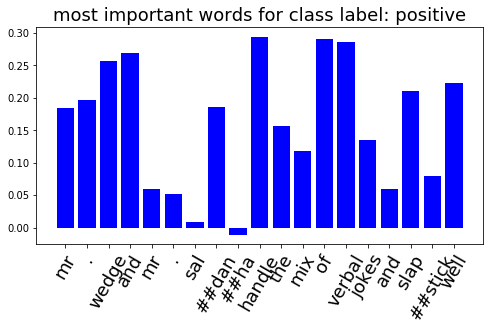

In [24]:
interpreter_msra.visualize(text)